In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,PowerTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import pickle
from scipy.stats import zscore
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv(r'https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv')

In [3]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.shape

(614, 13)

we have 614 row's of data 11 features and 1 label

In [5]:
data.set_index('Loan_ID',inplace=True)

# DATA PRE PROCESSING

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [7]:
data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Gender,Married,Dependents,Employed,LoanAmount,Laon_amount_term,credit history are missing values

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(614, 12)

no duplicate data available in the dataset

In [10]:
data['Gender'].fillna('unknown',inplace=True)

In [11]:
data['Married'].fillna('unknown',inplace=True)

In [12]:
data['Dependents'].fillna('unknown',inplace=True)

In [13]:
data['Self_Employed'].fillna('unknown',inplace=True)

In [14]:
data['LoanAmount'].fillna(data['LoanAmount'].mean(),inplace=True)

In [15]:
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0],inplace=True)

In [16]:
data['Credit_History'].fillna(data['Credit_History'].mode()[0],inplace=True)

In [17]:
data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [19]:
cat_data = data.select_dtypes('object').columns.tolist()

In [20]:
cont_data = data.select_dtypes(['int64','float64']).columns.tolist()

In [21]:
cat_data

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [22]:
cont_data

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [23]:
for i in data[cat_data]:
    print(f'{data[cat_data][i].nunique()}\n{data[cat_data][i].value_counts()}\n')

3
Male       489
Female     112
unknown     13
Name: Gender, dtype: int64

3
Yes        398
No         213
unknown      3
Name: Married, dtype: int64

5
0          345
1          102
2          101
3+          51
unknown     15
Name: Dependents, dtype: int64

2
Graduate        480
Not Graduate    134
Name: Education, dtype: int64

3
No         500
Yes         82
unknown     32
Name: Self_Employed, dtype: int64

3
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

2
Y    422
N    192
Name: Loan_Status, dtype: int64



In [24]:
data['Dependents'].replace({'0':'Zero','1':'One','2':'Two','3+':'More then Three'},inplace=True)

In [25]:
data['Dependents'].value_counts()

Zero               345
One                102
Two                101
More then Three     51
unknown             15
Name: Dependents, dtype: int64

In [26]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,Zero,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
LP001003,Male,Yes,One,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
LP001005,Male,Yes,Zero,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
LP001006,Male,Yes,Zero,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
LP001008,Male,No,Zero,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [27]:
cat_data.remove('Loan_Status')

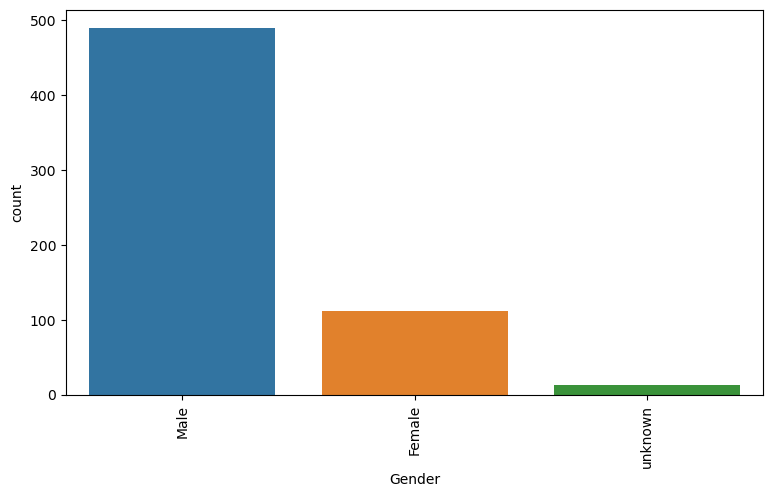

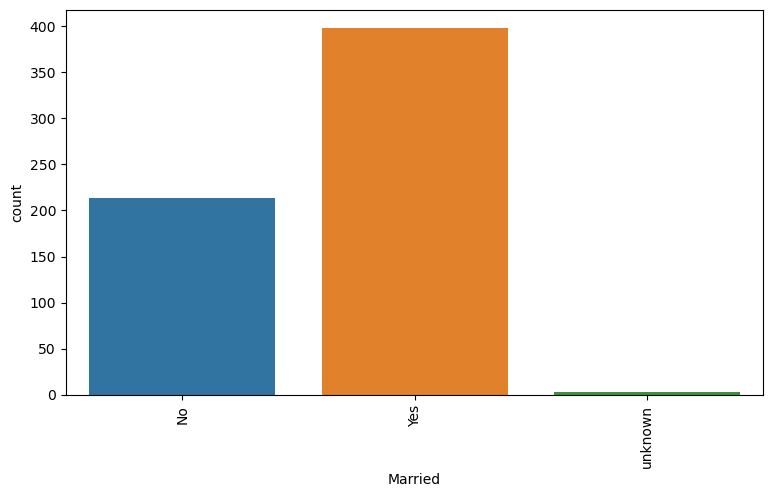

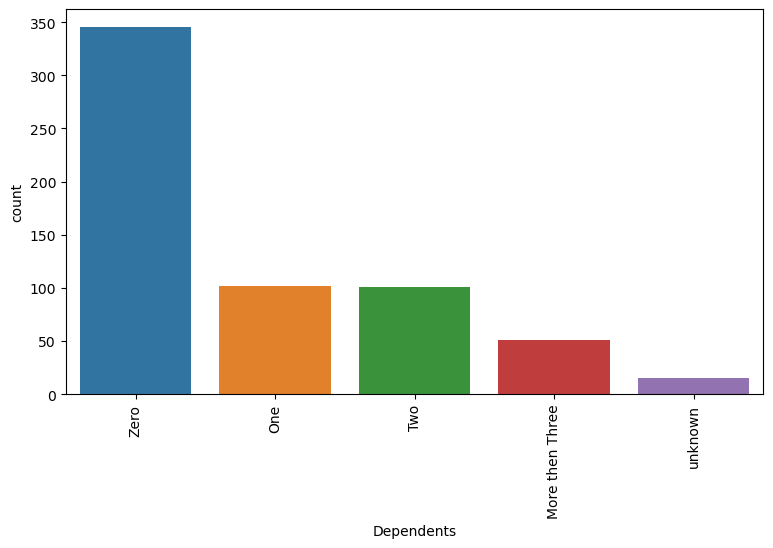

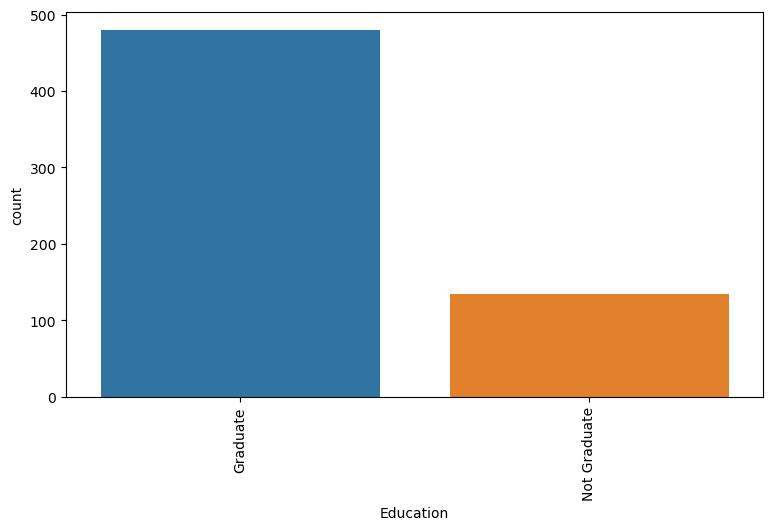

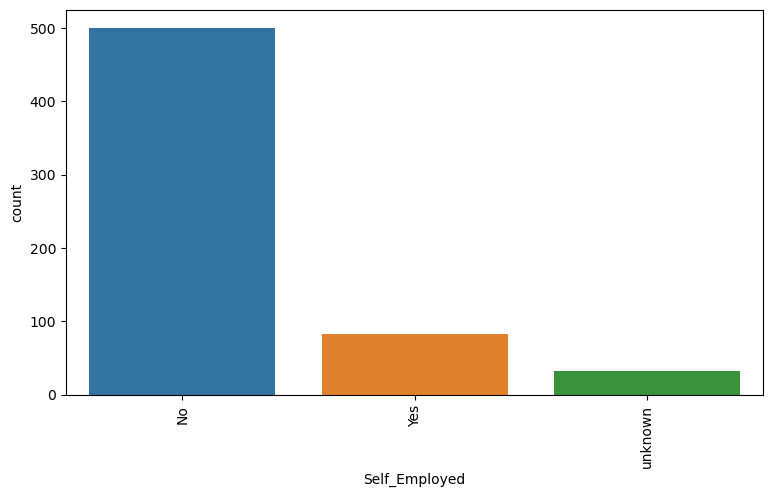

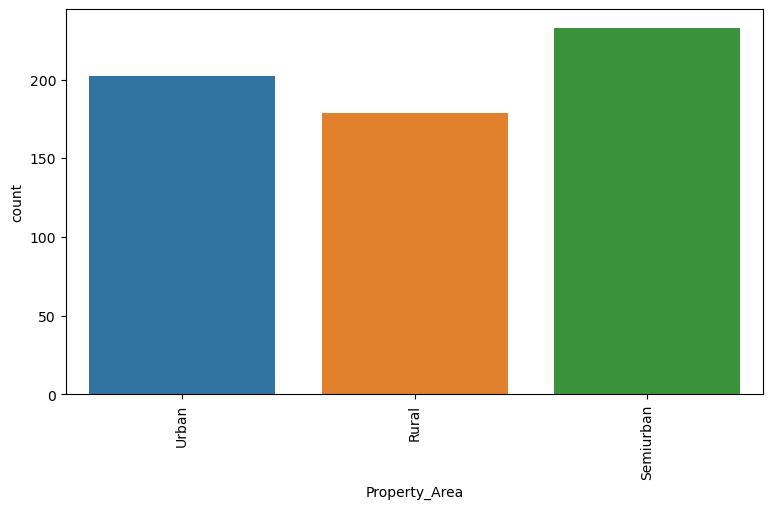

In [28]:
for i in data[cat_data]:
    plt.figure(figsize=(9,5))
    sns.countplot(x=data[cat_data][i])
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.show()

1. most of the applicants are Male

2. most of the applicants are married

3. most of the applicants have 0 dependents

4. most of the applicants are graduated

5. most of the applicants are not self employed

6. most applicants are from semi-urban area,then from urban and Rural respectively

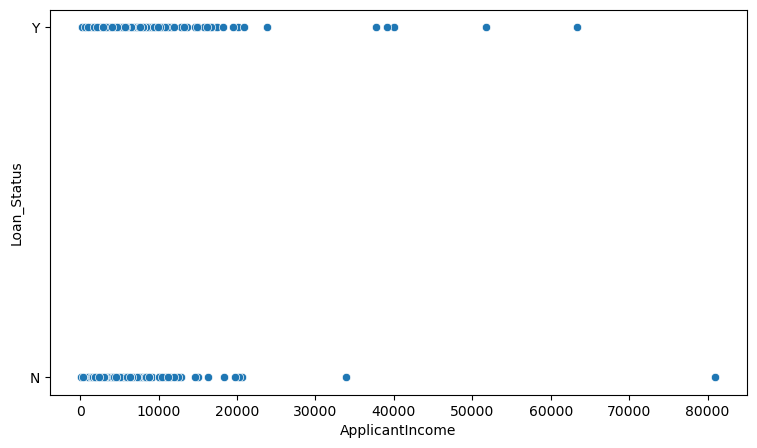

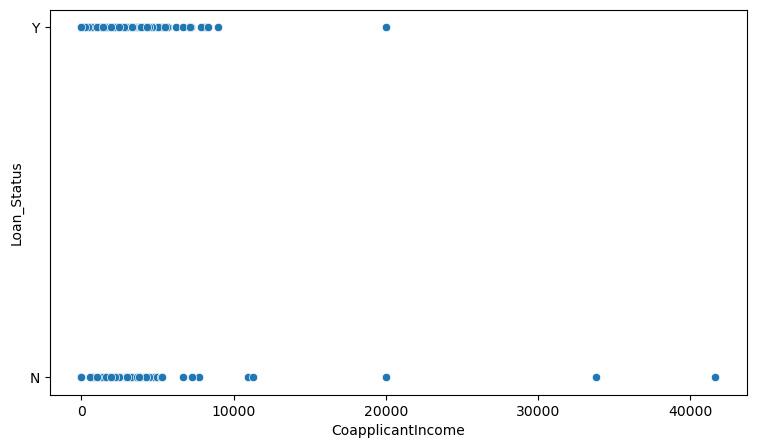

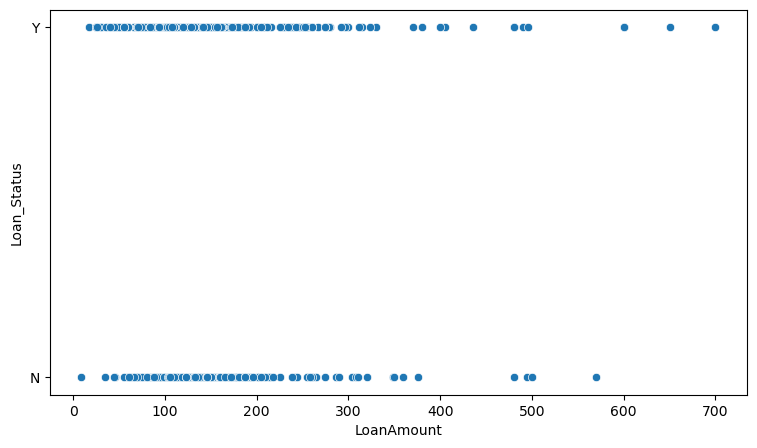

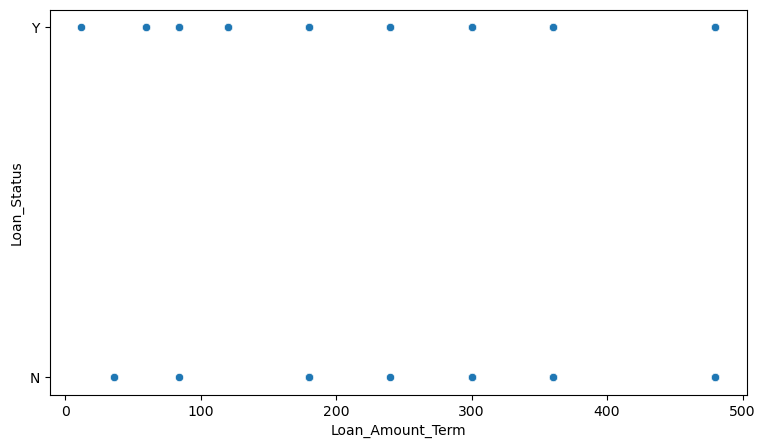

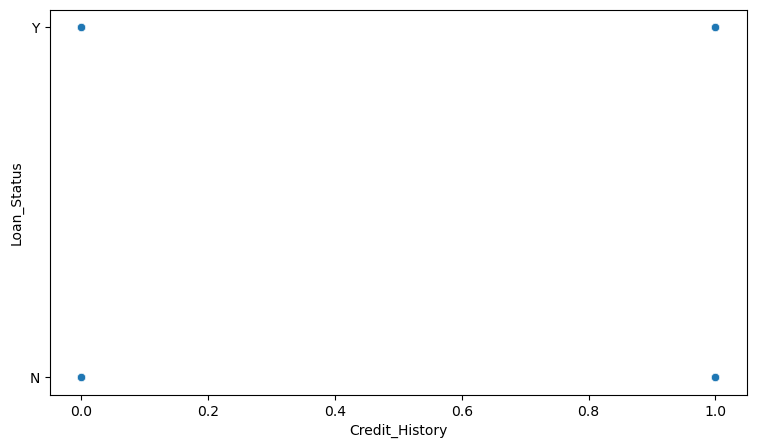

In [29]:
for i in data[cont_data]:
    plt.figure(figsize=(9,5))
    sns.scatterplot(x=data[cont_data][i],y = data['Loan_Status'])
    plt.xlabel(i)
    plt.show()

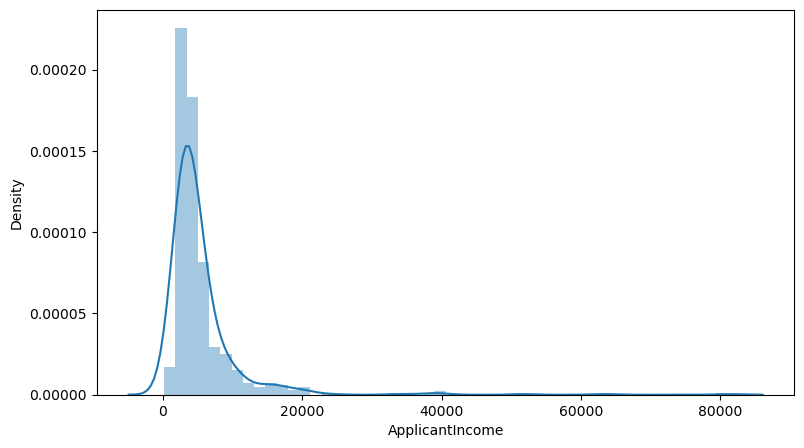

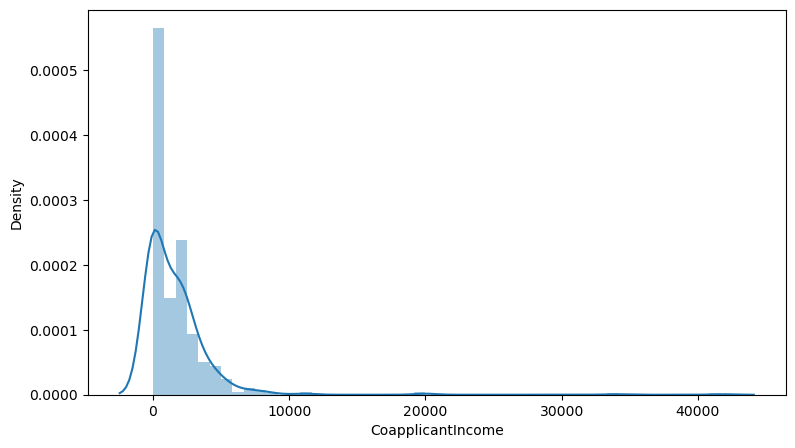

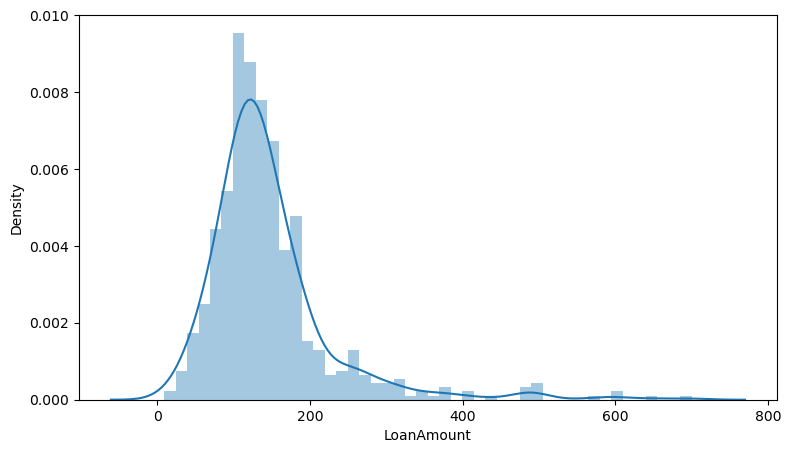

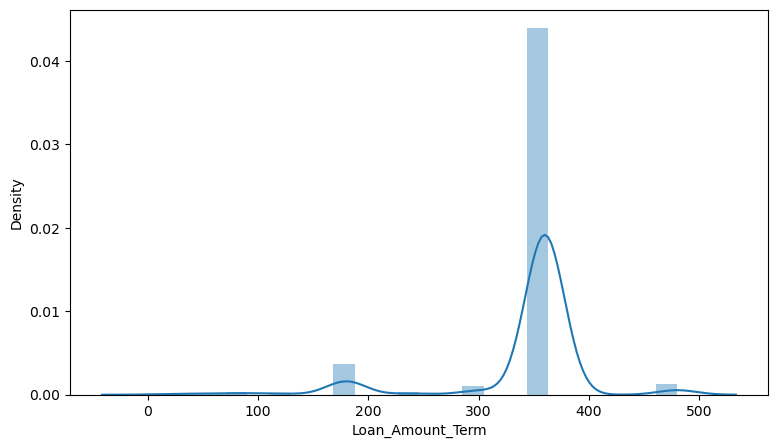

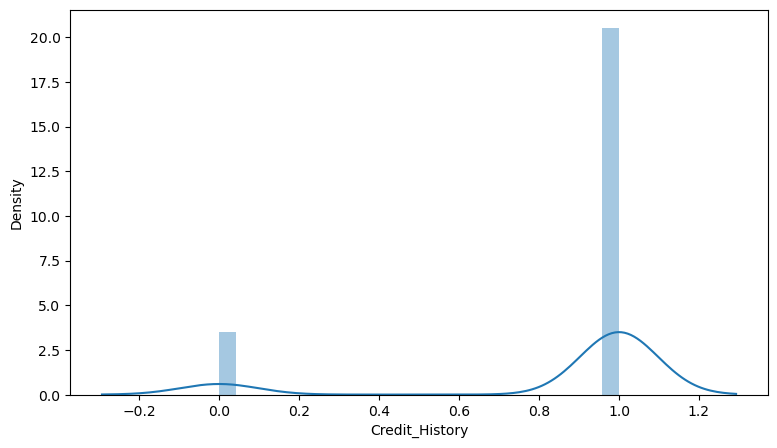

In [30]:
for i in data[cont_data]:
    plt.figure(figsize=(9,5))
    sns.distplot(data[cont_data][i])
    plt.xlabel(i)
    plt.show()

credit_history and loan_term_amount are discrete data

are features are normally distributed but have skewness

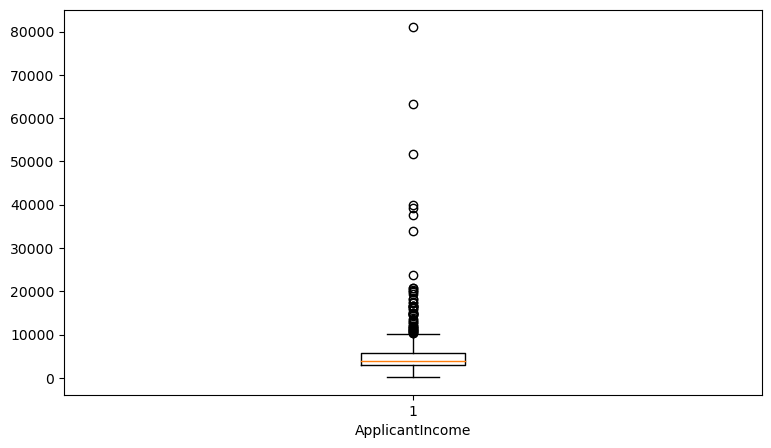

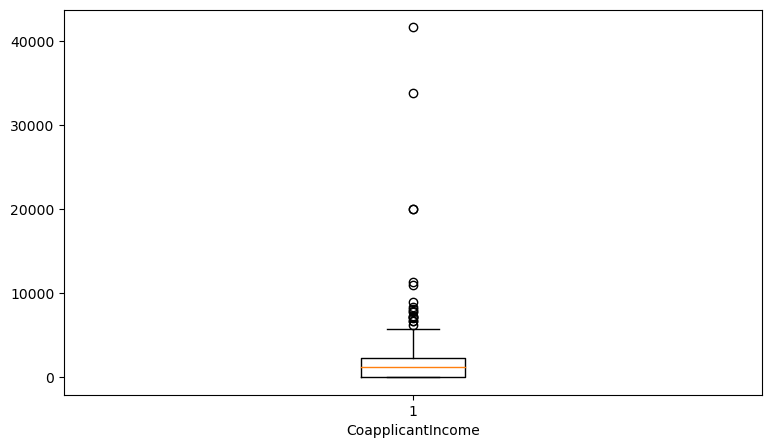

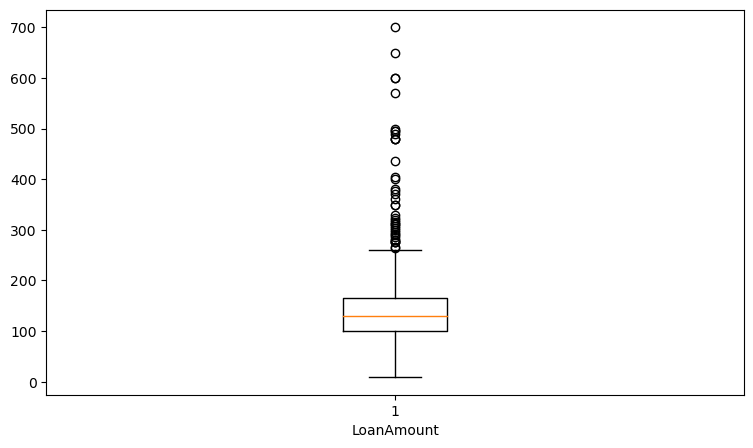

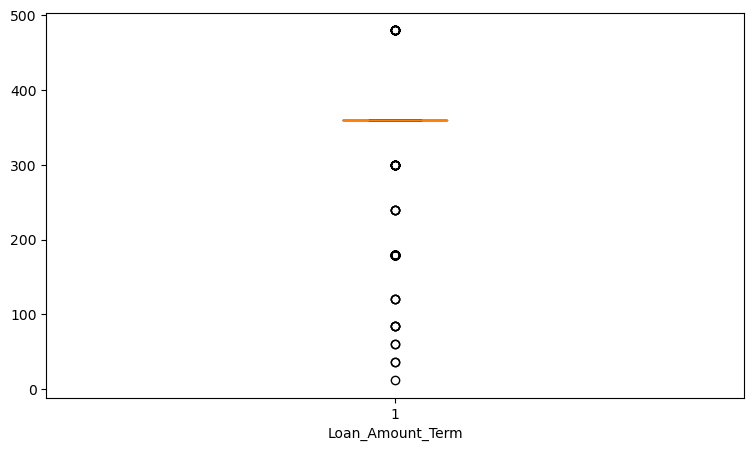

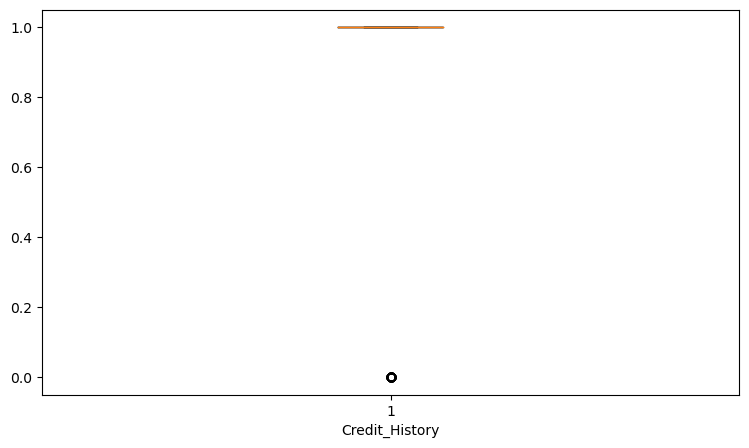

In [31]:
for i in data[cont_data]:
    plt.figure(figsize=(9,5))
    plt.boxplot(x=data[cont_data][i])
    plt.xlabel(i)
    plt.show()

also high amount of outliers are present in the data

In [32]:
data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [33]:
cat_data

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [34]:
cont_data

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

# Dealing with outliers

In [35]:
z = zscore(data[cont_data])

In [36]:
data = data[(z<3).all(axis=1)]

In [37]:
data.shape

(589, 12)

In [38]:
data_loss = (614-591)/614

In [39]:
data_loss

0.03745928338762215

In [40]:
data['Loan_Status'].replace({'Y':0,'N':1},inplace=True)

In [41]:
data['Loan_Status'].nunique()

2

In [42]:
data['Loan_Status'].value_counts()

0    407
1    182
Name: Loan_Status, dtype: int64

data set is not balanced

# Feature Selection

In [43]:
data.corr()['Loan_Status'].sort_values()

Credit_History      -0.555908
CoapplicantIncome   -0.044815
ApplicantIncome      0.005043
Loan_Amount_Term     0.023119
LoanAmount           0.042738
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

loanamount,applicant income and CoapplicantIncome have very less realtion with the target

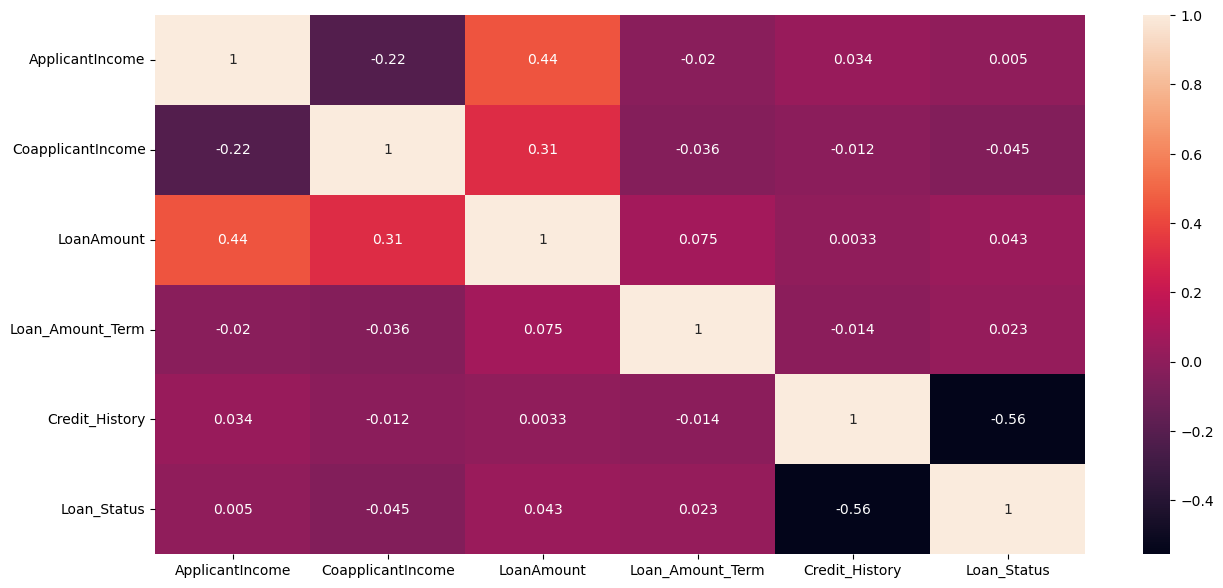

In [44]:
plt.figure(figsize=(15,7))

sns.heatmap(data.corr(),annot=True)

plt.show()

In [45]:
data.drop(['ApplicantIncome','ApplicantIncome','CoapplicantIncome'],axis=1,inplace=True)

In [46]:
data.shape

(589, 10)

In [47]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,
LP001002,Male,No,Zero,Graduate,No,146.412162,360.0,1.0,Urban,0
LP001003,Male,Yes,One,Graduate,No,128.000000,360.0,1.0,Rural,1
LP001005,Male,Yes,Zero,Graduate,Yes,66.000000,360.0,1.0,Urban,0
LP001006,Male,Yes,Zero,Not Graduate,No,120.000000,360.0,1.0,Urban,0
LP001008,Male,No,Zero,Graduate,No,141.000000,360.0,1.0,Urban,0


# SCALING AND TRANSFORMATION

In [48]:
cont_data.remove('LoanAmount')

In [49]:
cont_data.remove('ApplicantIncome')

In [50]:
cont_data.remove('CoapplicantIncome')

In [51]:
#dd = pd.get_dummies(data[cat_data])

In [52]:
#data = pd.concat([data,dd],axis=1)

In [53]:
le = LabelEncoder()

In [54]:
cat_data

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [55]:
data['Gender'] = le.fit_transform(data['Gender'])

In [56]:
data['Married'] = le.fit_transform(data['Married'])

In [57]:
data['Dependents'] = le.fit_transform(data['Dependents'])

In [58]:
data['Education'] = le.fit_transform(data['Education'])

In [59]:
data['Self_Employed'] = le.fit_transform(data['Self_Employed'])

In [60]:
data['Property_Area'] = le.fit_transform(data['Property_Area'])

In [61]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,
LP001002,1,0,3,0,0,146.412162,360.0,1.0,2,0
LP001003,1,1,1,0,0,128.000000,360.0,1.0,0,1
LP001005,1,1,3,0,1,66.000000,360.0,1.0,2,0
LP001006,1,1,3,1,0,120.000000,360.0,1.0,2,0
LP001008,1,0,3,0,0,141.000000,360.0,1.0,2,0


In [62]:
data.shape

(589, 10)

In [63]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,
LP001002,1,0,3,0,0,146.412162,360.0,1.0,2,0
LP001003,1,1,1,0,0,128.000000,360.0,1.0,0,1
LP001005,1,1,3,0,1,66.000000,360.0,1.0,2,0
LP001006,1,1,3,1,0,120.000000,360.0,1.0,2,0
LP001008,1,0,3,0,0,141.000000,360.0,1.0,2,0


In [64]:
data.shape

(589, 10)

In [65]:
x = data.drop('Loan_Status',axis=1)

y = data['Loan_Status']

# Scaling

In [66]:
x.skew().sort_values()

Loan_Amount_Term   -2.446026
Credit_History     -2.010069
Gender             -1.002998
Dependents         -0.921213
Married            -0.521379
Property_Area      -0.063183
LoanAmount          1.076221
Education           1.303332
Self_Employed       2.262000
dtype: float64

In [67]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=666)

In [68]:
x_train.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,
LP001238,1,1,0,1,1,125.0,60.0,1.0,2
LP002187,1,0,3,0,0,96.0,480.0,1.0,1
LP001882,1,1,0,0,0,160.0,360.0,0.0,2
LP002082,1,1,3,0,1,184.0,360.0,1.0,1
LP002314,0,0,3,1,0,66.0,360.0,1.0,0


In [69]:
ss = StandardScaler()

In [70]:
pt = PowerTransformer()

In [71]:
x_train[cont_data] = pt.fit_transform(x_train[cont_data])

In [72]:
x_test[cont_data] = pt.transform(x_test[cont_data])

In [73]:
x_train[cont_data] = ss.fit_transform(x_train[cont_data])

In [74]:
x_test[cont_data] = ss.transform(x_test[cont_data])

# Over Sampling

In [75]:
smote = SMOTE()

In [76]:
x_train,y_train = smote.fit_resample(x_train,y_train)

In [77]:
y_train.value_counts()

0    331
1    331
Name: Loan_Status, dtype: int64

# LR

In [78]:
lr = LogisticRegression()

In [79]:
lr.fit(x_train,y_train)

LogisticRegression()

In [80]:
pred1 = lr.predict(x_train)

In [81]:
pred2 = lr.predict(x_test)

In [82]:
print(f'Train Score: {accuracy_score(y_train,pred1)}')

Train Score: 0.7824773413897281


In [83]:
print(f'Test Score: {accuracy_score(y_test,pred2)}')

Test Score: 0.7711864406779662


In [84]:
a1 = accuracy_score(y_train,pred1)

In [85]:
a2 = accuracy_score(y_test,pred2)

In [86]:
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        76
           1       0.80      0.48      0.60        42

    accuracy                           0.77       118
   macro avg       0.78      0.71      0.72       118
weighted avg       0.78      0.77      0.75       118



In [87]:
print(confusion_matrix(y_test,pred2))

[[71  5]
 [22 20]]


In [88]:
cv = cross_val_score(lr,x,y)

a3 = cv.mean()

a3

0.8149500217296828

# KNN

In [89]:
knn = KNeighborsClassifier()

In [90]:
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [91]:
pred3 = knn.predict(x_train)

In [92]:
pred4 = knn.predict(x_test)

In [93]:
print(f'Train Score: {accuracy_score(y_train,pred3)}')

Train Score: 0.8368580060422961


In [94]:
print(f'Test Score: {accuracy_score(y_test,pred4)}')

Test Score: 0.6779661016949152


In [95]:
a4 = accuracy_score(y_train,pred3)

In [96]:
a5 = accuracy_score(y_test,pred4)

In [97]:
print(classification_report(y_test,pred4))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        76
           1       0.56      0.48      0.51        42

    accuracy                           0.68       118
   macro avg       0.64      0.63      0.64       118
weighted avg       0.67      0.68      0.67       118



In [98]:
print(confusion_matrix(y_test,pred4))

[[60 16]
 [22 20]]


In [99]:
cv = cross_val_score(knn,x,y)

a6 = cv.mean()

a6

0.6469071418223962

# DT

In [100]:
dt = DecisionTreeClassifier()

In [101]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [102]:
pred5 = dt.predict(x_train)

In [103]:
pred6 = dt.predict(x_test)

In [104]:
print(f'Train Score: {accuracy_score(y_train,pred5)}')

Train Score: 0.9954682779456193


In [105]:
print(f'Test Score: {accuracy_score(y_test,pred6)}')

Test Score: 0.7203389830508474


In [106]:
a7 = accuracy_score(y_train,pred5)

In [107]:
a8 = accuracy_score(y_test,pred6)

In [108]:
print(classification_report(y_test,pred6))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        76
           1       0.66      0.45      0.54        42

    accuracy                           0.72       118
   macro avg       0.70      0.66      0.67       118
weighted avg       0.71      0.72      0.71       118



In [109]:
print(confusion_matrix(y_test,pred6))

[[66 10]
 [23 19]]


In [110]:
cv = cross_val_score(dt,x,y)

a9 = cv.mean()

a9

0.72152687237433

# RF

In [111]:
rf = RandomForestClassifier()

In [112]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [113]:
pred7 = rf.predict(x_train)

In [114]:
pred8 = rf.predict(x_test)

In [115]:
print(f'Train Score: {accuracy_score(y_train,pred7)}')

Train Score: 0.9954682779456193


In [116]:
print(f'Test Score: {accuracy_score(y_test,pred8)}')

Test Score: 0.788135593220339


In [117]:
a10 = accuracy_score(y_train,pred7)

In [118]:
a11 = accuracy_score(y_test,pred8)

In [119]:
print(classification_report(y_test,pred8))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        76
           1       0.81      0.52      0.64        42

    accuracy                           0.79       118
   macro avg       0.80      0.73      0.74       118
weighted avg       0.79      0.79      0.77       118



In [120]:
print(confusion_matrix(y_test,pred8))

[[71  5]
 [20 22]]


In [121]:
cv = cross_val_score(rf,x,y)

a12 = cv.mean()

a12

0.77083876575402

# ADA

In [122]:
ada = AdaBoostClassifier()

In [123]:
ada.fit(x_train,y_train)

AdaBoostClassifier()

In [124]:
pred9 = ada.predict(x_train)

In [125]:
pred10 = ada.predict(x_test)

In [126]:
print(f'Train Score: {accuracy_score(y_train,pred9)}')

Train Score: 0.8383685800604229


In [127]:
print(f'Test Score: {accuracy_score(y_test,pred10)}')

Test Score: 0.7627118644067796


In [128]:
a13 = accuracy_score(y_train,pred9)

In [129]:
a14 = accuracy_score(y_test,pred10)

In [130]:
print(classification_report(y_test,pred10))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83        76
           1       0.77      0.48      0.59        42

    accuracy                           0.76       118
   macro avg       0.77      0.70      0.71       118
weighted avg       0.76      0.76      0.75       118



In [131]:
print(confusion_matrix(y_test,pred10))

[[70  6]
 [22 20]]


In [132]:
cv = cross_val_score(ada,x,y)

a15 = cv.mean()

a15

0.7996523250760539

# GBDT

In [133]:
gb = GradientBoostingClassifier()

In [134]:
gb.fit(x_train,y_train)

GradientBoostingClassifier()

In [135]:
pred11 = gb.predict(x_train)

In [136]:
pred12 = gb.predict(x_test)

In [137]:
print(f'Train Score: {accuracy_score(y_train,pred11)}')

Train Score: 0.8836858006042296


In [138]:
print(f'Test Score: {accuracy_score(y_test,pred12)}')

Test Score: 0.8050847457627118


In [139]:
a16 = accuracy_score(y_train,pred11)

In [140]:
a17 = accuracy_score(y_test,pred12)

In [141]:
print(classification_report(y_test,pred12))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        76
           1       0.88      0.52      0.66        42

    accuracy                           0.81       118
   macro avg       0.83      0.74      0.76       118
weighted avg       0.82      0.81      0.79       118



In [142]:
print(confusion_matrix(y_test,pred12))

[[73  3]
 [20 22]]


In [143]:
cv = cross_val_score(gb,x,y)

a18 = cv.mean()

a18

0.7894828335506301

# XGBOOST

In [144]:
xg = XGBClassifier()

In [145]:
xg.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [146]:
pred13 = xg.predict(x_train)

In [147]:
pred14 = xg.predict(x_test)

In [148]:
print(f'Train Score: {accuracy_score(y_train,pred13)}')

Train Score: 0.9848942598187311


In [149]:
print(f'Test Score: {accuracy_score(y_test,pred14)}')

Test Score: 0.7542372881355932


In [150]:
a19 = accuracy_score(y_train,pred13)

In [151]:
a20 = accuracy_score(y_test,pred14)

In [152]:
print(classification_report(y_test,pred14))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        76
           1       0.70      0.55      0.61        42

    accuracy                           0.75       118
   macro avg       0.74      0.71      0.72       118
weighted avg       0.75      0.75      0.75       118



In [153]:
print(confusion_matrix(y_test,pred14))

[[66 10]
 [19 23]]


In [154]:
cv = cross_val_score(xg,x,y)

a21 = cv.mean()

a21

0.7470520063740402

# SVM

In [155]:
svm = SVC()

In [156]:
svm.fit(x_train,y_train)

SVC()

In [157]:
pred15 = svm.predict(x_train)

In [158]:
pred16 = svm.predict(x_test)

In [159]:
print(f'Train Score: {accuracy_score(y_train,pred15)}')

Train Score: 0.527190332326284


In [160]:
print(f'Test Score: {accuracy_score(y_test,pred16)}')

Test Score: 0.3135593220338983


In [161]:
a22 = accuracy_score(y_train,pred15)

In [162]:
a23 = accuracy_score(y_test,pred16)

In [163]:
print(classification_report(y_test,pred16))

              precision    recall  f1-score   support

           0       0.41      0.16      0.23        76
           1       0.28      0.60      0.38        42

    accuracy                           0.31       118
   macro avg       0.35      0.38      0.31       118
weighted avg       0.37      0.31      0.28       118



In [164]:
print(confusion_matrix(y_test,pred16))

[[12 64]
 [17 25]]


In [165]:
cv = cross_val_score(svm,x,y)

a24 = cv.mean()

a24

0.6910039113428944

In [166]:
train = []
test = []
cv = []

In [167]:
train.append(a1)
test.append(a2)
cv.append(a3)

train.append(a4)
test.append(a5)
cv.append(a6)

train.append(a7)
test.append(a8)
cv.append(a9)

train.append(a10)
test.append(a11)
cv.append(a12)

train.append(a13)
test.append(a14)
cv.append(a15)

train.append(a16)
test.append(a17)
cv.append(a18)

train.append(a19)
test.append(a20)
cv.append(a21)

train.append(a22)
test.append(a23)
cv.append(a24)

In [168]:
model = ['LR','KNN','DT','RF','ADA','GBDT','XGBOOST','SVM']

In [169]:
result = pd.DataFrame({'MODELS':model,'TRAIN RESULT':train,'TEST RESULT':test,'CV SCORE':cv})

In [170]:
result

,MODELS,TRAIN RESULT,TEST RESULT,CV SCORE
0,LR,0.782477,0.771186,0.814950
1,KNN,0.836858,0.677966,0.646907
2,DT,0.995468,0.720339,0.721527
3,RF,0.995468,0.788136,0.770839
4,ADA,0.838369,0.762712,0.799652
5,GBDT,0.883686,0.805085,0.789483
6,XGBOOST,0.984894,0.754237,0.747052
7,SVM,0.527190,0.313559,0.691004


we want model which can  predict weather the loan will be sanctioned or not, so we want f1 score on ('Y':0) so we are chosing the GBDT model

# HYPER PARAMETER TUNING

In [171]:
gb = GradientBoostingClassifier()

In [172]:
para = {'loss':['log_loss', 'deviance', 'exponential'],
        'n_estimators':[100,150,200],
       'learning_rate':[0.001,0.01,0.1,1,10],
       'criterion':['friedman_mse', 'squared_error'],
       'min_samples_split':[2,3,4],
       'min_samples_leaf':[1,2],
       'max_depth':[3,4,5]}

In [173]:
gs = GridSearchCV(gb,para,n_jobs=-1)

In [174]:
gs.fit(x_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['log_loss', 'deviance', 'exponential'],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200]})

In [175]:
gs.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [176]:
gs.best_estimator_.fit(x_train,y_train)

GradientBoostingClassifier(loss='deviance', max_depth=5, n_estimators=200)

In [177]:
trainpred = gs.best_estimator_.predict(x_train)

In [178]:
testpred = gs.best_estimator_.predict(x_test)

In [179]:
print(f'Train Score: {accuracy_score(y_train,trainpred)}')

Train Score: 0.9939577039274925


In [180]:
print(f'Test Score: {accuracy_score(y_test,testpred)}')

Test Score: 0.7542372881355932


In [181]:
cv = cross_val_score(gs.best_estimator_,x,y)

cv_mean = cv.mean()

cv_mean

0.7436766623207302

In [182]:
conclusion = pd.DataFrame({'Actual':y_test,'PREDICTED':testpred})

In [183]:
conclusion

,Actual,PREDICTED
Loan_ID,,
LP001531,1,0
LP001657,1,0
LP002894,0,0
LP001900,0,0
LP001280,0,0
...,...,...
LP002776,1,1
LP001350,0,0
LP001926,0,0


In [184]:
print(classification_report(y_test,testpred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        76
           1       0.71      0.52      0.60        42

    accuracy                           0.75       118
   macro avg       0.74      0.70      0.71       118
weighted avg       0.75      0.75      0.74       118



In [185]:
print(confusion_matrix(y_test,testpred))

[[67  9]
 [20 22]]


In [186]:
fpr,tpr,threshold = roc_curve(y_test,testpred)

In [187]:
roc_auc_score(y_test,testpred)

0.7026942355889724

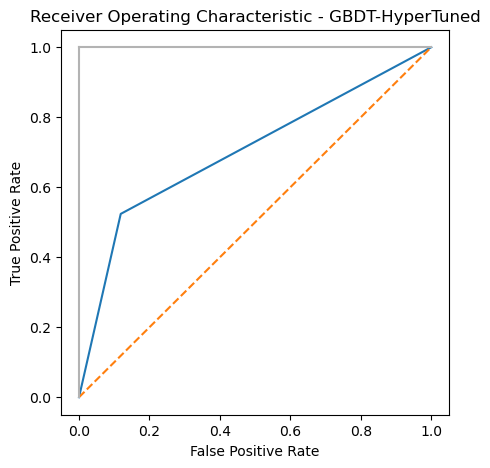

In [188]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - GBDT-HyperTuned')
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [189]:
pickle.dump(gs.best_estimator_,open('loan_pred.pkl','wb'))